In [1]:
# apply Jupyter notebook style
from IPython.core.display import HTML

from custom.styles import style_string

HTML(style_string)


<div style="text-align:center;">
  <img src="custom/molssi_main_horizontal.png" style="display: block; margin: 0 auto; max-height:200px;">
</div>

# Introduction to Data Fitting with SciKitLearn

<div class="overview admonition"> 
<p class="admonition-title">Overview</p>

Questions:

* How do I fit a model using SciKitLearn?

* How can I use SciKitLearn to assess my model?

* How can I use other models from the SciKitLearn library?

Objectives:

* Fit a linear model using SciKitLearn.
    
* Use train_test_split to split the data.

* Try other models from SciKitLearn.

</div>

When people think of "machine learning" they usually are thinking of things like "neural networks".
However, "machine learning" really is just fitting data with various models, neural networks being on possible model type.
"Machine learning" encompasses a broad array of algorithms, many of which are simpler than neural networks and might be more appropriate for specific tasks. SciKit-Learn, a foundational Python library in data fitting and machine learning, has a large of such algorithms that cater to both regression and classification problems.
Conveniently, SciKit-Learn also uses a particular format for its models that allows you to switch out models.

In this notebook, we will see how to use scikitlearn to fit chemical data to linear models. However, the concepts outlined here will be relevant to fitting data to other models.

## Data Loading and Visualization

Before fitting our models, we will first load our data using pandas and visualize the linear relationships using seaborn.
For a review of pandas and seaborn, see notebok `03_python_data_science`.

For this lesson, we will be loading amino acid data from an SDF file using RDKit and pandas tools, then fitting models to molecular relationships using SciKit-Learn.

In [31]:
import pandas as pd # for dataframes

import seaborn as sns # for graphs

from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(True) # make molecule images show up

df = pd.read_csv("data/delaney-processed.csv")

In [32]:
df.head(3) # preview the first three rows.

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)


We have now loaded our solubility data using pandas.
We can use the skills we learned in the previous lesson to use RDKit to add RDKit molecule objects to our data frame.

In [33]:
from rdkit import Chem

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),

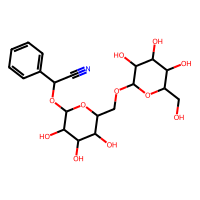
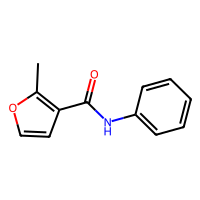
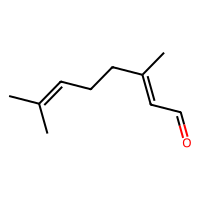

In [34]:
df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)
df.head(3)

For our introduction to SciKit-Learn, we will be fitting a very simple relationship - the number of heavy atoms in a molecule and the molecular weight. These will obviously correlated, but we use it as an example to demonstrate fitting data with SciKit-Learn models.

We will need to add this descriptor to our dataframe.


In [35]:
from rdkit.Chem import Descriptors

df["NumHeavyAtoms"] = df["mol"].apply(Descriptors.HeavyAtomCount)

### Visualizing Correlation

One way to visualize the relationship between different variables is to use a pandas correlation matrix.
This is available on a dataframe using [df.corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html). 
This will return a dataframe that shows the correlation between each variable and every other variable.

In [36]:
df.corr(numeric_only=True)

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,NumHeavyAtoms
ESOL predicted log solubility in mols per litre,1.000000,-0.110001,-0.679967,0.282070,-0.496116,-0.249812,0.189204,0.907264,-0.592453
Minimum Degree,-0.110001,1.000000,-0.096719,-0.130664,0.246020,-0.175626,-0.189464,-0.130445,-0.024945
Molecular Weight,-0.679967,-0.096719,1.000000,0.254877,0.652521,0.396894,0.475440,-0.640189,0.921623
Number of H-Bond Donors,0.282070,-0.130664,0.254877,1.000000,0.211087,0.077002,0.755932,0.209429,0.328216
Number of Rings,-0.496116,0.246020,0.652521,0.211087,1.000000,-0.136654,0.308606,-0.512279,0.761396
Number of Rotatable Bonds,-0.249812,-0.175626,0.396894,0.077002,-0.136654,1.000000,0.286723,-0.244256,0.424505
Polar Surface Area,0.189204,-0.189464,0.475440,0.755932,0.308606,0.286723,1.000000,0.123210,0.575924
measured log solubility in mols per litre,0.907264,-0.130445,-0.640189,0.209429,-0.512279,-0.244256,0.123210,1.000000,-0.585638
NumHeavyAtoms,-0.592453,-0.024945,0.921623,0.328216,0.761396,0.424505,0.575924,-0.585638,1.000000


The correlation ranges from 0 (not correlated) to 1 (correlated). The correlation of a column with itself is 1.
We can combine this with a heatmap function in seaborn to see this visually.

<Axes: >

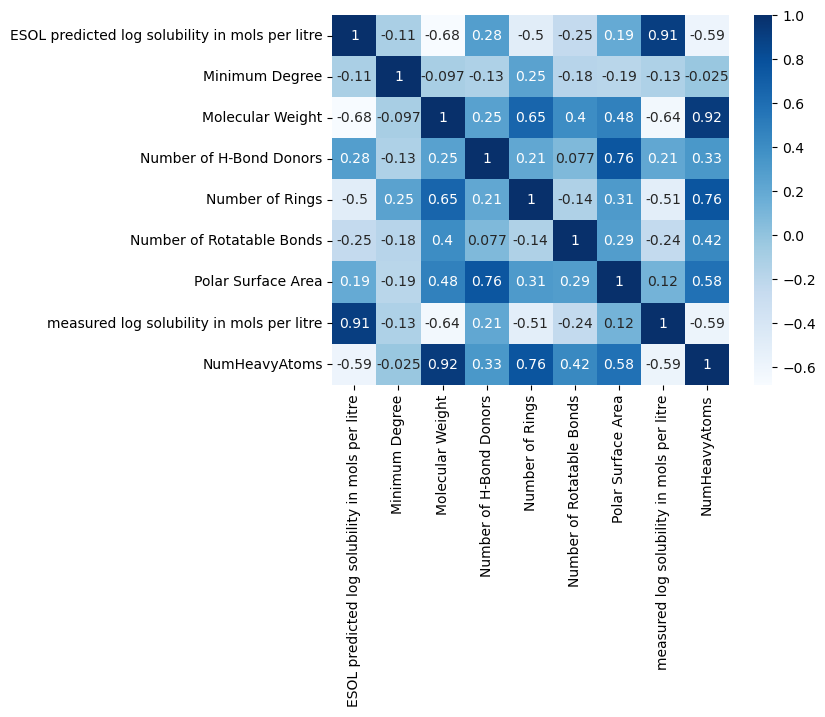

In [37]:
sns.heatmap(df.corr(numeric_only=True), cmap="Blues", annot=True)

## Fitting using SciKitLearn

[Scikit-learn](https://scikit-learn.org/stable/index.html) is a popular machine learning library in Python that provides a wide range of algorithms for supervised and unsupervised learning, including classification, regression, clustering, and dimensionality reduction. It is built on top of NumPy, SciPy, and matplotlib, and provides a simple and efficient API for working with data in Python. 

For our simple example, we will fit a linear relationship between the number of heavy atoms and the molecular weight. As a reminder, the equation for a linear relationship is $y = mx + b$.
Molecular weight and number of heavy atoms will obviously be correlated, but is a good demonstration of how to use the scikitlearn library.
All model fits in Scikit-Learn use [a similar API](https://scikit-learn.org/stable/developers/develop.html#apis-of-scikit-learn-objects), so learning how to do a linear fit will directly translate to other models.



In [38]:
from sklearn.linear_model import LinearRegression # import the linear regression model

from sklearn.metrics import r2_score, mean_squared_error

In [39]:
# Get our x and y data
X = df[["NumHeavyAtoms"]]
Y = df[["Molecular Weight"]]

linear_model = LinearRegression()
linear_model.fit(X,Y)

LinearRegression()

That's it! That is how we fit a SciKit Learn model to our data. 
Now, our variable `linear_model` is a trained SciKit Learn model.
We can use it to predict new values or evaluate our model.

First, we will look at the score for the model on our training data.
This score will range from 0 to 1, with a value closer to 1 indicating a better fit.

In [40]:
linear_model.score(X, Y)

0.8493895158261833

Our model score is `0.84`. This indicates that heavy atom count and molecular weight have a linear relationship,
but it may be less correlated than we expect.
We will examine this later in the notebook.

Our trained model, `linear_model` now has a method called `predict`. 
If we put in values for our dependent variable, our model will return what values our model
will predict.
To visualize how well our model does, we will compare our model predicted values to our
observed values.

In [41]:
# use the model to make predictions and add it to the graph
model_values = linear_model.predict(X)

# Save our predicted values in a new column in our dataframe.
df["PredictedWt"] = model_values

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol,NumHeavyAtoms,PredictedWt
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,,32,461.486688
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,,15,227.477146
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),,11,172.416077

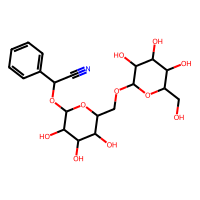
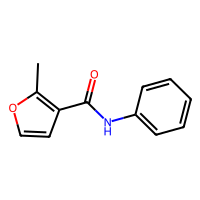
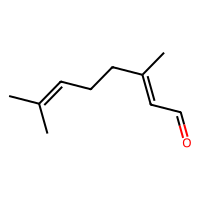

In [42]:
df.head(3)

We will now use seaborn to visualize our actual and predicted values.
This plot shows the `MolWt` as the x value, with the predicted `MolWt` as the Y value.
The `MolWt` vs itself is shown as a reference line. For a perfect model,
all values would fall along the line.

<Axes: xlabel='Molecular Weight', ylabel='PredictedWt'>

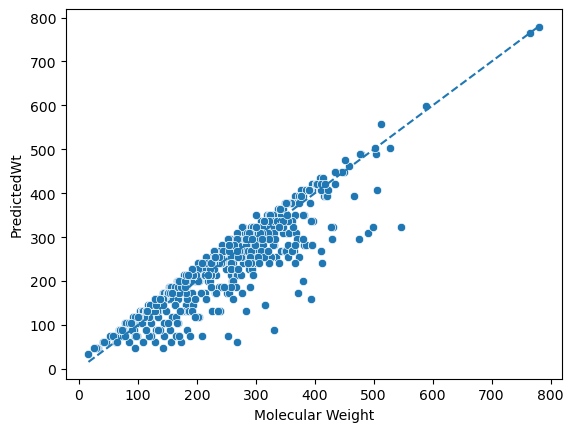

In [43]:
sns.scatterplot(x="Molecular Weight", y="PredictedWt", data=df)
sns.lineplot(x="Molecular Weight", y="Molecular Weight", data=df, linestyle='--')

In [44]:
import math

# Evaluate the model's performance
mse = mean_squared_error(Y, model_values)
rmse = math.sqrt(mse)
r2 = r2_score(Y, model_values)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)

Mean Squared Error: 1588.301287449386
Root Mean Squared Error: 39.853497806960256
R2 Score: 0.8493895158261833


<div class="exercise admonition">
<p class="admonition-title">Exercise - Multilinear Regression

<p> To perform multilinear regression, you only need to feed in two columns of data for X. Then, you perform the fit the same way. </p>
    
```python
X = df[["MolWt", "Polar Surface Area"]]
```

Now, you will be fitting an equation of the form $y = m_{1}x_{1} + m_{2}x_{2} +b$.  
    
</div>

In [16]:
df.columns

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles', 'mol',
       'NumHeavyAtoms', 'PredictedWt'],
      dtype='object')

In [48]:
X = df[["NumHeavyAtoms", "Polar Surface Area"]]
Y = df[["Molecular Weight"]]

multilinear_model = LinearRegression()
multilinear_model.fit(X,Y)

LinearRegression()

In [49]:
# use the model to make predictions and add it to the graph
model_values = multilinear_model.predict(X)

# Save our predicted values in a new column in our dataframe.
df["PredictedWt_MultilinearModel"] = model_values

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol,NumHeavyAtoms,PredictedWt,PredictedWt_MultilinearModel
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,,32,461.486688,434.551954
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,,15,227.477146,226.923908
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),,11,172.416077,175.065597
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,,22,323.834016,338.423908
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,,5,89.824474,92.304392

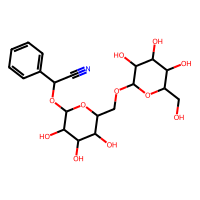
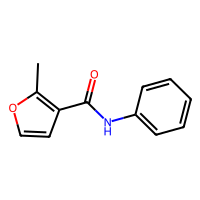
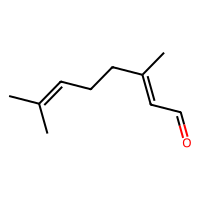
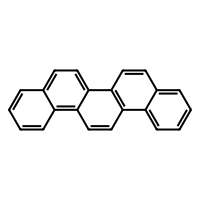
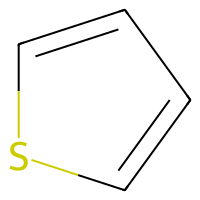

In [50]:
df.head()

<Axes: xlabel='Molecular Weight', ylabel='PredictedWt_MultilinearModel'>

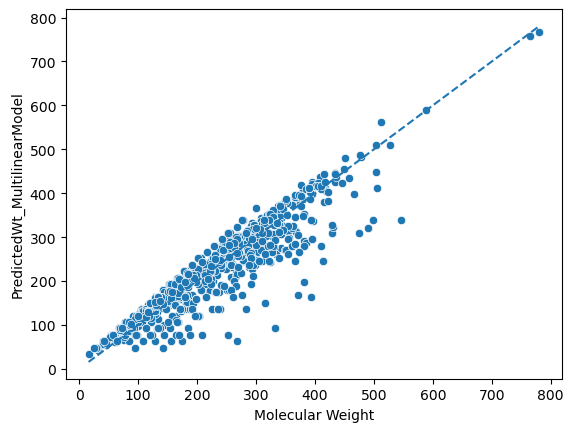

In [51]:
sns.scatterplot(x="Molecular Weight", y="PredictedWt_MultilinearModel", data=df)
sns.lineplot(x="Molecular Weight", y="Molecular Weight", data=df, linestyle='--')

In [52]:
import math

# Evaluate the model's performance
mse = mean_squared_error(Y, model_values)
rmse = math.sqrt(mse)
r2 = r2_score(Y, model_values)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)

Mean Squared Error: 1539.9673158687685
Root Mean Squared Error: 39.24241730409543
R2 Score: 0.8539727790391034


## Model Validation - Train Test Split

When training a model for machine learning, it is a best practice to evaluate the model's performance on data that was not part of the training set.
One way to achieve this is to use a method called "train test split".

Train-test split is a widely used technique in the field of machine learning and data science to evaluate the performance of a model. It involves dividing the available data into two distinct sets: a training set and a testing set. This partitioning is essential to ensure that the model generalizes well to new, unseen data and to prevent overfitting.

The primary purposes of using train-test split are:

Model validation: To ensure that the model built using the training data performs well on unseen data, the testing set serves as a proxy for new data. By comparing the model's predictions with the actual outcomes in the testing set, we can gauge its predictive accuracy and robustness.

Prevent overfitting: Overfitting occurs when a model learns to perform exceptionally well on the training data but fails to generalize to new data. This is usually due to the model capturing the noise or random fluctuations in the training data rather than the underlying patterns. A train-test split helps mitigate this issue by allowing us to evaluate the model's performance on a separate dataset.

To perform a train-test split, the data is typically divided into approximately 70-80% for training and 20-30% for testing. This ratio can be adjusted depending on the size and characteristics of the dataset. The split should be done randomly to ensure that both sets are representative of the overall data distribution.

SciKit-Learn has tools that can split your data for you. We will now use `train-test-split` and repeat our analysis.

In [53]:
# Train test split

from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

Now we perform a fit using the training data only.

In [55]:
ttt_model = LinearRegression()
ttt_model.fit(X_train, Y_train)

LinearRegression()

After performing our fit with the training data, we use the "test" data to evaluate the model.

In [56]:
y_pred = ttt_model.predict(X_test)

In [57]:
df_train = pd.DataFrame()
df_train["Molecular Weight"] = Y_test
df_train["Predicted MolWt"] = y_pred

<Axes: xlabel='Molecular Weight', ylabel='Predicted MolWt'>

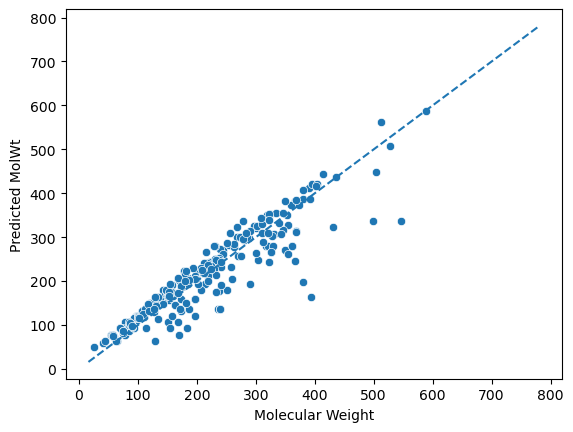

In [58]:
sns.scatterplot(x="Molecular Weight", y="Predicted MolWt", data =df_train)
sns.lineplot(x="Molecular Weight", y="Molecular Weight", data=df, linestyle='--')

In [59]:
import math

# Evaluate the model's performance
mse = mean_squared_error(Y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(Y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)

Mean Squared Error: 1669.386531958343
Root Mean Squared Error: 40.85812687775032
R2 Score: 0.8522502192506366


In [60]:
# Compare it to model performance on the training data.

y_pred = ttt_model.predict(X_train)


# Evaluate the model's performance
mse = mean_squared_error(Y_train, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(Y_train, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)

Mean Squared Error: 1497.129827649488
Root Mean Squared Error: 38.69276195426592
R2 Score: 0.8545636016223443


## The SciKit Learn Model API

All scikit learn models use the same API, or interface. This means to switch from a linear model to a more sophisticated model like a [random forest model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), one need only change
the model creation.

For example, recall our code to fit a linear model and use it for prediction:

```python
from sklearn.linear_model import LinearRegression 

model = LinearRegression()
model.fit(X,Y)
predictions = model.predict(X)
```

To do the same thing with a random forest regresso, the code would be:


```python
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, Y)
predictions = model.predict()

```

<div class="exercise admonition">
<p class="admonition-title">Exercises - Challenge</p>

<p> Repeat this analysis for your the vitamins data set or the amino acids dataset provided.</p>

We have provided starter code for reading an SDF file into a pandas dataframe using PandasTools. 
    If you are interested in learning more about this, see  [Supplemental Notebook: RDKit PandasTools](supplemental_PandasTools.ipynb)

Do you see any differences in trends observed for the amino acid dataset compared to the ESOL dataset?
Is the relationship between number of heavy atoms and molecular weight a better fit?
Do you have any hypotheses why or why not?
</p>
</div>

In [62]:
from rdkit.Chem import PandasTools

PandasTools.RenderImagesInAllDataFrames(True)

df2 = PandasTools.LoadSDF("data/amino_acids/amino_acids-nat20.sdf", strictParsing=False)

,ID,ROMol
0,Ala,
1,Arg,

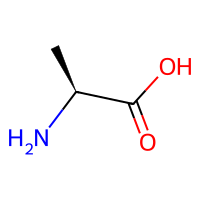
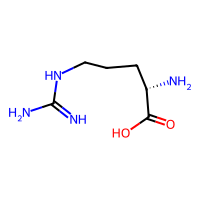

In [63]:
df2.head(2)

In [64]:
# Add to data set
df2["Molecular Weight"] = df2["ROMol"].apply(Descriptors.MolWt)
df2["NumHeavyAtoms"] = df2["ROMol"].apply(Descriptors.HeavyAtomCount)

In [78]:
Y = df2[["Molecular Weight"]]
X = df2[["NumHeavyAtoms"]]

aa_model = LinearRegression()
aa_model.fit(X, Y)

y_pred = aa_model.predict(X)

In [79]:
df_train = pd.DataFrame()
df_train["Molecular Weight"] = Y
df_train["Predicted MolWt"] = y_pred

<Axes: xlabel='Molecular Weight', ylabel='Predicted MolWt'>

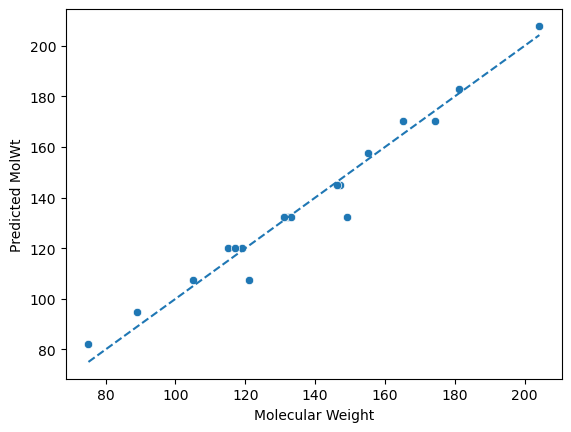

In [80]:
sns.scatterplot(x="Molecular Weight", y="Predicted MolWt", data =df_train)
sns.lineplot(x="Molecular Weight", y="Molecular Weight", data=df2, linestyle='--')